# Interior Point Predictor Corrector example

This notebook will run an example of the Interior Point Predictor-Corrector algorithm. 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

Let us define the problem we want to solve

In [2]:
m=2
n=2
A=np.array([[-1, 1],[1,1]])
b=np.array([[0],[2]])
c=np.array([[0],[1]])
print(2**7)

128


Starting point

In [3]:
x0=np.array([[1],[1]])
z0=np.array([[1],[1]])
y0=np.array([[0],[0]])

Additional calculated parameters

In [4]:
#Additional parameters
bbar=b-np.matmul(A,x0)
cbar=c-np.matmul(np.transpose(A),y0)-z0
gbar=np.matmul(np.transpose(c),x0)+1-np.matmul(np.transpose(b),y0)

Define x, z, tau and kappa

In [5]:
#Initialization
z=z0
x=x0
y=y0
tau=np.array([[1]])
kappa=np.array([[1]])
theta=np.array([[1]])

In [6]:
def CalculateM(A,b,c,bbar,cbar,gbar,x,z,tau,kappa):
    n=len(c)
    m=len(b)
    M=np.block([
        [np.zeros((m,m)), A, -b, bbar, np.zeros((m,n+1))],
        [-np.transpose(A), np.zeros((n,n)), c, -cbar, -np.identity(n), np.zeros((n,1))],
        [np.transpose(b),-np.transpose(c), np.zeros(1), gbar, np.zeros((1,n)), -np.identity(1)],
        [-np.transpose(bbar),np.transpose(cbar),-gbar,np.zeros((1, n+2))],
        [np.zeros((n,m)), np.diag(np.transpose(z)[0]), np.zeros((n,2)), np.diag(np.transpose(x)[0]), np.zeros((n,1))],
        [np.zeros((1,n+m)), kappa, np.zeros((1, 1+n)), tau]
    ])
    return M

Define the f vector

In [7]:
def Calculatef(gamma,x,z,tau,kappa):
    n=len(x)
    mu=(np.matmul(np.transpose(x),z)+np.matmul(tau,kappa))/(n+1)
    f=np.block([
        [np.zeros((m,1))],
        [np.zeros((n,1))],
        [0],
        [0],
        [gamma*mu*np.ones((n,1))-np.matmul(np.diag(np.transpose(x)[0]),z)],
        [gamma*mu-np.matmul(tau,kappa)],
    ])
    return f

Define termination criteria for termination

In [8]:
epsilon1=.001
epsilon2=.001
epsilon3=.001

Define the neighbour

In [9]:
def Isinneighbourhood(d,beta):
    #We decompose the vector d
    y,x,tau,theta,z,kappa=Decompose(d)
    #Calculation of whether d is in the neighbour of the central path
    vector=np.block([
        [np.matmul(np.diag(np.transpose(x)[0]),z)],
        [np.matmul(tau,kappa)]
    ])
    mu=(np.matmul(np.transpose(x),z)+np.matmul(tau,kappa))/(len(x)+1)
    vector -= mu*np.ones((len(x)+1,1))
    norm=np.linalg.norm(vector,2)
    if norm<=beta*mu:
        return True
    else:
        return False

In [10]:
#def acceptable(d0,d,delta,beta):
    #this function returns d+delta*d0 if the point is in the neighbour and 0 otherwise
    #return (d0+delta*d)*Isinneighbourhood(d0+delta*d,beta)

In [11]:
def Predict(M,f,d0):
    d=np.linalg.solve(M,f)
    delta = np.linspace(0, 1)
    acceptable = lambda delta: delta*Isinneighbourhood(d0+delta*d,.5)
    deltamax=max(delta, key=acceptable)
    return d0+deltamax*d

In [12]:
def Correct(M,f,d0):
    d=np.linalg.solve(M,f)
    return d+d0

In [13]:
def Decompose(d): #Extracts (y,x,tau,theta,z,kappa) from d
    y=d[0:m]
    x=d[m:m+n]
    tau=d[m+n]
    theta=d[m+n+1]
    z=d[m+n+2:m+2*n+2]
    kappa=d[m+2*n+2]
    return y,x,tau,theta,z,kappa

In [14]:
def Compose(y,x,tau,theta,z,kappa): #Creates d from (y,x,tau,theta,z,kappa)
    d=np.block([
        [y],
        [x],
        [tau],
        [theta],
        [z],
        [kappa]
    ])
    return d

In [15]:
#Main program
iteration=0
results={}
while True:
    #Check if we can terminate
    c1=float(np.matmul(np.transpose(x),z)/np.matmul(tau,tau))
    c2=float((theta/tau)*np.linalg.norm(np.concatenate([bbar,cbar]),2))
    c3=float(tau)

    print(c1,c2,c3)
    print('Iteration :',iteration)
    print('x/tau = ',x/tau )
    print('y/tau = ',y/tau )
    print('z/tau = ',z/tau )
    results[iteration]=(x/tau,y/tau,z/tau)

    if (abs(c1)<=epsilon1 and abs(c2)<=epsilon2):
        print('Success, iteration:', iteration)
        break
    elif (abs(c3)<=epsilon3):
        print('No solution, iteration:', iteration)
        break

    #Main iteration
    iteration+=1

    #Predict step
    f=Calculatef(0,x,z,tau,kappa)
    print(f)
    M=CalculateM(A,b,c,bbar,cbar,gbar,x,z,tau,kappa)
    print(M)
    d0=Compose(y,x,tau,theta,z,kappa)
    d0=Predict(M,f,d0)
    y,x,tau,theta,z,kappa=Decompose(d0)

    #Correct step
    f=Calculatef(1,x,z,tau,kappa)
    print(f)
    M=CalculateM(A,b,c,bbar,cbar,gbar,x,z,tau,kappa)
    print(M)
    d0=Compose(y,x,tau,theta,z,kappa)
    d0=Correct(M,f,d0)
    y,x,tau,theta,z,kappa=Decompose(d0)

2.0 1.0 1.0
Iteration : 0
x/tau =  [[1.]
 [1.]]
y/tau =  [[0.]
 [0.]]
z/tau =  [[1.]
 [1.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-1.]
 [-1.]
 [-1.]]
[[ 0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1. -2.  0.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  1. -1. -0.  0.]
 [-1. -1.  0.  0.  1.  0. -0. -1.  0.]
 [ 0.  2.  0. -1.  0.  2.  0.  0. -1.]
 [ 0.  0. -1.  0. -2.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1. -2.  0.  0.  0.  0.]
 [ 1. -1.  0.  0.  0.  1. -1. -0.  0.]
 [-1. -1.  0.  0.  1.  0. -0. -1.  0.]
 [ 0.  2.  0. -1.  0.  2.  0.  0. -1.]
 [ 0.  0. -1.  0. -2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]
0.0 0.0 1.0
Iteration : 1
x/tau =  [[1.]
 [1.]]
y/tau =  [[0.5]
 [0.5]]
z/tau =  [[0.

[1.0, 1.0] [1.0, 1.0]
[0.0, 0.5] [0.0, 0.5]
[1.0, 0.0] [1.0, 0.0]


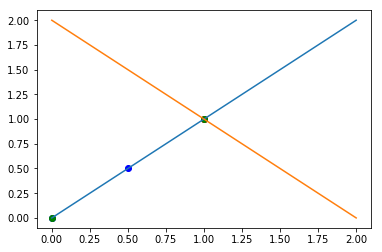

In [16]:
xx=[]
xy=[]
yx=[]
yy=[]
zx=[]
zy=[]
for i in range(iteration+1):
    xx.append(float(results[i][0][0]))
    xy.append(float(results[i][0][1]))
    yx.append(float(results[i][1][0]))
    yy.append(float(results[i][1][1]))
    zx.append(float(results[i][2][0]))
    zy.append(float(results[i][2][1]))
print(xx,xy)
print(yx,yy)
print(zx,zy)
plt.plot(xy,xx,'ro') #x is depicted in red
plt.plot(yy,yx,'bo') #y is depicted in blue
plt.plot(zy,zx,'go') #z is depicted in green
#print(results[0][0])


s=np.linspace(0,2,10)
f1=s  #This functions are encoded in A and b, if A and b change, so must this functions
f2=2-s #
plt.plot(f1,s)
plt.plot(f2,s)
plt.show()